<a href="https://colab.research.google.com/github/marianaadmc/TFG-Procesamiento-de-imagenes-de-fluorescencia-FISH-/blob/main/Notebook_definitivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Las primeras celdas son la instalación e importación de los paquetes y herramientas que serán necesarios a lo largo del proyecto.

In [1]:
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.0 MB/s eta 0:00:00


In [2]:
import ipywidgets as widgets
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from skimage.measure import label, regionprops
from skimage import filters, io, color, img_as_ubyte
from skimage.io import imread, imshow
from skimage import filters
from skimage.morphology import disk
from skimage import feature
import matplotlib.colors as color
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.color import rgb2gray

# **Selección de imágenes**

Esta sección consiste en la implementación de un dropdown para seleccionar la imagen que se quiere procesar. Si quiere analizar otra imagen distinta después, debe ejecutar todo el código desde aquí.

Dropdown(description='Selecciona una imagen:', options=('image2472.jpg', 'image0161.jpg', 'image2949.jpg', 'im…

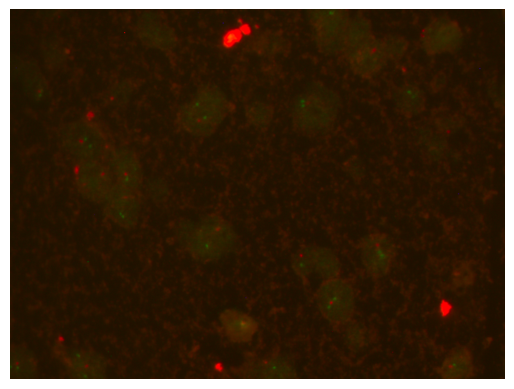

In [36]:
image_names = ['image2472.jpg', 'image0161.jpg', 'image2949.jpg', 'image0794-1P.jpg', 'image0796-1P.jpg', 'image0797-1P.jpg', 'image0799-19Q.jpg', 'image0801-19Q.jpg']

image_dropdown = widgets.Dropdown(options=image_names, description='Selecciona una imagen:')

def show_selected_image(change):
    selected_image = change['new']
    img_path = f'{selected_image}'
    img = io.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


image_dropdown.observe(show_selected_image, names='value')


display(image_dropdown)

In [37]:
image = io.imread(f'{image_dropdown.value}')

# **SET UP MÉTODO AUTOMÁTICO SAM**

Se importan y definen los métodos necesarios para la ejecución del método SAM.

In [23]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [24]:
using_colab = True

In [25]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.3.0+cu121
Torchvision version: 0.18.0+cu121
CUDA is available: False
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-d43ysfbn
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-d43ysfbn
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=4d02b5a2280cc1ef975e4314de7c9468611a2537855e8c68fbd49f4ab7da35d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-jy6jdwyq/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-06-25 09:38:28--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.co

In [26]:
#Función para mostrar las máscaras
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = [np.concatenate([np.random.random(3), [0.35]])]
        img[m] = color_mask
    ax.imshow(img)

In [27]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

## Ajuste de parámetros para mask_generator_2

In [ ]:
mask_generator_sondas = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32, #Los puntos que forman la red del modelo sobre la imagen
    pred_iou_thresh=0.86,  #Calidad mínima
    stability_score_thresh=0.92,  #Calidad mínima
    crop_n_layers=1,
    crop_n_points_downscale_factor=0.25, #Mejora la detección de objetos pequeños
    min_mask_region_area=0,  #Tamaño mínimo de objeto que segmenta
)

# **Detección de sondas**

Solamente con el "mask_generator_2" con los parámetros adecuados y un filtrado por tamaño conseguimos segmentar sólo las sondas.

El problema es que no distingue entre el color de las sondas ni entre las que están dentro o fuera de la célula. Además, no reconoce todas las sondas.

In [ ]:
masks_sondas = mask_generator_sondas.generate(image)

In [ ]:
#Filtro el tamaño de las máscaras para que sólo muestre las de las sondas.
masks_sondas_filtrar_tamaño = []
for mask in masks_sondas:
  if mask['area'] < 150 and mask['area'] > 0:
    masks_sondas_filtrar_tamaño.append(mask)

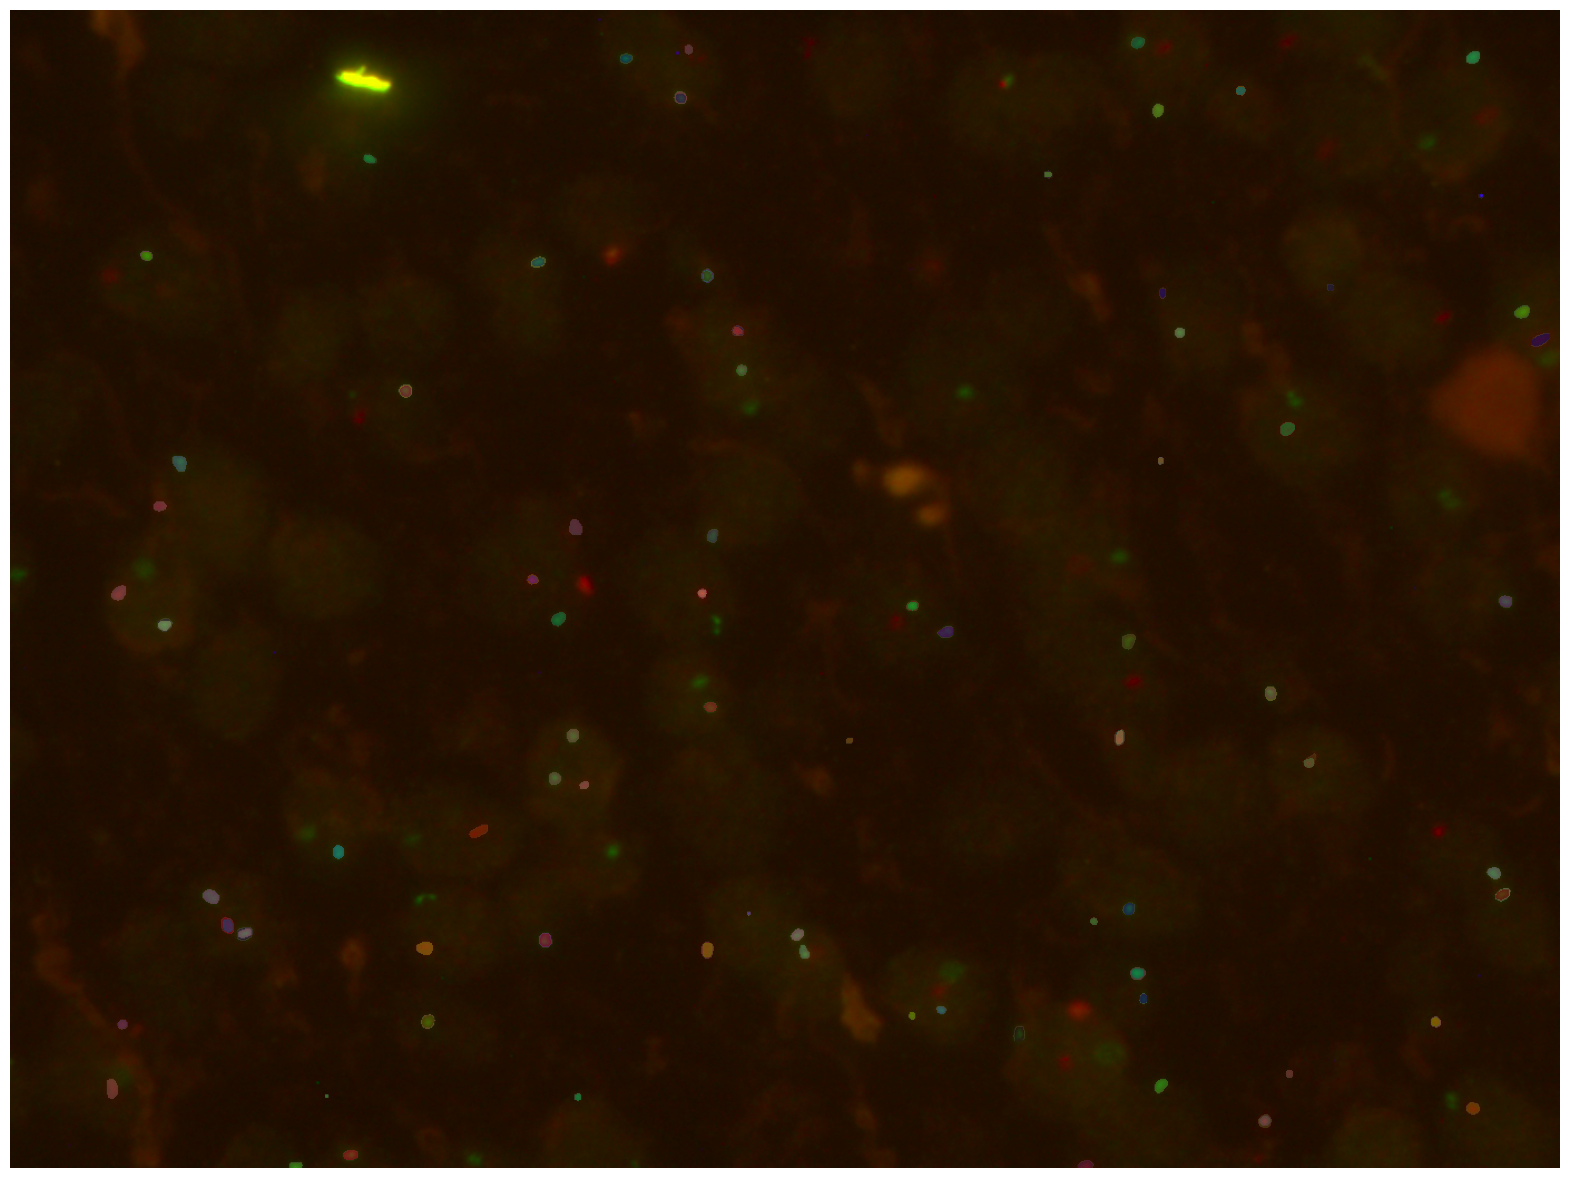

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks_sondas_filtrar_tamaño)
plt.axis('off')
plt.show()

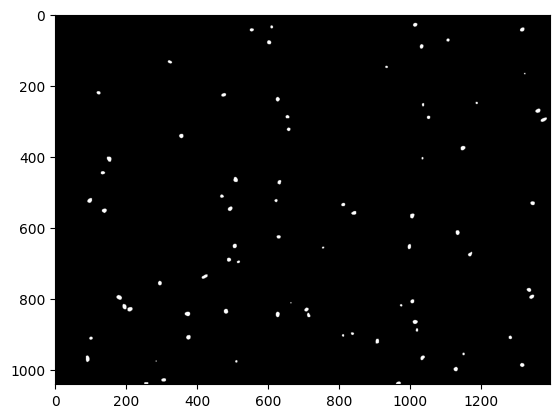

In [ ]:
sondas_bin = np.zeros(image.shape[:2])
for mask in masks_sondas_filtrar_tamaño:
  mask = mask['segmentation']
  for x in range(0, mask.shape[0]):
    for y in range(0, mask.shape[1]):
      if mask[x][y] == True:
        sondas_bin[x][y] = 1
plt.imshow(sondas_bin, cmap='gray')

# **Detección del color de las sondas**

A partir de las sondas detectadas y el canal h de la imagen original en HSV, se diferencian las sondas por color.

In [ ]:
hsv = color.rgb_to_hsv(image)

canal_h = hsv[:,:,0]

plt.imshow(canal_h, cmap='hsv')

In [ ]:
label_image = label(sondas_bin)
regions = regionprops(label_image)
props = regionprops(label_image)

masc_sondas_rojas = np.zeros(sondas_bin.shape)
masc_sondas_verdes = np.zeros(sondas_bin.shape)
for prop in props:
  coords = prop.centroid
  if str(canal_h[int(coords[0])][int(coords[1])])[:3] == '0.0' or str(canal_h[int(coords[0])][int(coords[1])])[:3] == '0.9':
    for x in range(prop.bbox[0], prop.bbox[2]):
      for y in range(prop.bbox[1], prop.bbox[3]):
        if sondas_bin[x][y] == 1:
          masc_sondas_rojas[x][y] = 1
  else:
    for x in range(prop.bbox[0], prop.bbox[2]):
      for y in range(prop.bbox[1], prop.bbox[3]):
        if sondas_bin[x][y] == 1:
          masc_sondas_verdes[x][y] = 1

In [ ]:
plt.imshow(sondas_bin, cmap = 'gray')
plt.show()
plt.imshow(masc_sondas_rojas, cmap = 'gray')
plt.show()
plt.imshow(masc_sondas_verdes, cmap = 'gray')
plt.show()

# **Detección de células**

In [ ]:
# Función que muestra un box azul
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))
# Función que muestra un box naranja
def show_box2(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='orange', facecolor=(0,0,0,0), lw=2))

In [ ]:
image_gris = rgb2gray(image)

In [ ]:
umbral_li = filters.threshold_li(image_gris)
li = image_gris > umbral_li

image_bin = np.zeros(li.shape)
for x in range(0, li.shape[0]):
  for y in range(0, li.shape[1]):
    if li[x][y] == True:
      image_bin[x][y] = 1


In [ ]:
dic_colores = {
    1: [0, 153, 0],  # Verde
    2: [153, 0, 153],  # Morado
    3: [255, 255, 0],  # Amarillo
    4: [0, 255, 255],  # Cian
    5: [255, 102, 102],  # Rosa
    6: [0, 0, 255],  # Azul
    7: [255, 0, 255],  # Magenta
    8: [128, 128, 0],  # Oliva
    9: [0, 255, 0],  # Lima
    10: [75, 0, 130],  # Índigo
    11: [139, 69, 19],  # Siena
    12: [153, 0, 0],  # Marrón
    13: [0, 128, 128],  # Teal
    14: [130, 0, 75],  # Borgoña
    15: [153, 153, 0],  # Amarillo verdoso
    16: [128, 0, 128],  # Púrpura
    17: [255, 0, 0],  # Rojo (añadido para completar hasta la clave 21)
    18: [0, 255, 0],  # Verde lima (añadido para completar hasta la clave 21)
    19: [0, 0, 255],  # Azul (añadido para completar hasta la clave 21)
    20: [255, 255, 255],  # Blanco (añadido para completar hasta la clave 21)
    21: [102, 102, 255],
    22: [102, 255, 102],
    23: [75, 130, 0],
    24: [0, 130, 75],
    25: [19, 139, 69],
    26: [69, 19, 139],
    27: [102, 102, 0],
    28: [0, 69, 102],
    29: [102, 255, 0],
    30: [0, 255, 128],
}

In [ ]:
boxes = []
min_area = 3000
label_image = label(image_bin)
regions = regionprops(label_image)
bw_filtered = np.zeros_like(image_bin)
for region in regions:
    if min_area <= region.area:
        bw_filtered[label_image == region.label] = 1
masc_cels = np.zeros(image.shape)
plt.imshow(bw_filtered, cmap = 'gray')
props = regionprops(label_image)
print("Propiedades de las regiones:")
for i, prop in enumerate(props):
    if prop.area > 3000:
      print(f"Región {i + 1}: Área = {prop.area}, BoundingBox = {prop.bbox}")
      if prop.area > 9000:
        reg = bw_filtered[prop.bbox[0]:prop.bbox[2], prop.bbox[1]:prop.bbox[3]]
        distance = ndi.distance_transform_edt(reg)
        coords = peak_local_max(distance.astype(int), footprint=disk(50), labels=reg.astype(int))
        mask = np.zeros(distance.shape, dtype=bool)
        mask[tuple(coords.T)] = True
        markers, _ = ndi.label(mask)
        labels = watershed(-distance, markers, mask=reg)

        fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
        ax = axes.ravel()



        ax[0].imshow(reg, cmap=plt.cm.gray)
        ax[0].set_title('Overlapping objects')
        ax[1].imshow(-distance, cmap=plt.cm.gray)
        ax[1].set_title('Distances')
        ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
        ax[2].set_title('Separated objects')

        for a in ax:
            a.set_axis_off()

        fig.tight_layout()
        plt.show()

        for x in range(prop.bbox[0], prop.bbox[2]):
          for y in range(prop.bbox[1], prop.bbox[3]):
            if labels[x-prop.bbox[0]][y-prop.bbox[1]] != 0 and labels[x-prop.bbox[0]][y-prop.bbox[1]] <= 30:
              masc_cels[x][y][0] = dic_colores[labels[x-prop.bbox[0]][y-prop.bbox[1]]][0]
              masc_cels[x][y][1] = dic_colores[labels[x-prop.bbox[0]][y-prop.bbox[1]]][1]
              masc_cels[x][y][2] = dic_colores[labels[x-prop.bbox[0]][y-prop.bbox[1]]][2]
            elif labels[x-prop.bbox[0]][y-prop.bbox[1]] > 30:
              masc_cels[x][y][0] = dic_colores[labels[x-prop.bbox[0]][y-prop.bbox[1]]-30][0]
              masc_cels[x][y][1] = dic_colores[labels[x-prop.bbox[0]][y-prop.bbox[1]]-30][1]
              masc_cels[x][y][2] = dic_colores[labels[x-prop.bbox[0]][y-prop.bbox[1]]-30][2]
      else:
        boxes.append([prop.bbox[0], prop.bbox[2], prop.bbox[1], prop.bbox[3]])
for box in boxes:
  for x in range(box[0], box[1]):
    for y in range(box[2], box[3]):
      if bw_filtered[x][y] != 0:
        masc_cels[x][y][0] = 255
        masc_cels[x][y][1] = 0
        masc_cels[x][y][2] = 255

In [ ]:
plt.imshow(masc_cels)

# **Resultados**

Recuento de sondas de cada color en cada célula para ofrecer resultados numéricos y en imágenes.

## Imágenes

In [ ]:
bin_por_masc = []
for i in dic_colores.keys():
  bin = np.zeros(masc_cels.shape[:2])
  for x in range(0, masc_cels.shape[0]):
    for y in range(0, masc_cels.shape[1]):
      if masc_cels[x][y][0] == dic_colores[i][0] and masc_cels[x][y][1] == dic_colores[i][1] and masc_cels[x][y][2] == dic_colores[i][2]:
        bin[x][y] = 1
  bin_por_masc.append(bin)

In [ ]:
min_area = 1000
cels = dict()
for x, bin in enumerate(bin_por_masc):
  label_image = label(bin)
  regions = regionprops(label_image)
  bw_filtered = np.zeros_like(bin)
  for region in regions:
      if min_area <= region.area:
          bw_filtered[label_image == region.label] = 1
  plt.imshow(bw_filtered, cmap = 'gray')
  plt.show()

  props = regionprops(label_image)
  print("Propiedades de las regiones:")
  for i, prop in enumerate(props):
    if prop.area > 1000:
      print(f"Región {i + 1}: Área = {prop.area}, BoundingBox = {prop.bbox}")
      cels[f'Célula {i+1} máscara {x+1}'] = [prop.bbox, prop["coords"]]

In [ ]:
'''
Función que me dice si dos bounding boxes intersectan
'''
def intersects(rectangle,rectangle2):
    min_row, min_col, max_row, max_col = rectangle
    min_row2, min_col2, max_row2, max_col2 = rectangle2


    return not (max_col < min_col2
                or min_col > max_col2
                or max_row < min_row2
                or min_row > max_row2)
'''
Función que me dice si las coordenadas de una región coinciden en algún punto
con las coordenadas de otra región.
(Si realmente se toca)
'''
def intersect_points(coords1,coords2):
    reg = 0
    for point1 in coords1:
        for point2 in coords2:
            if (point1[0] == point2[0]) and (point1[1] == point2[1]):
              reg+=1
    if reg == len(coords2):
        return True
    return False

In [ ]:
label_img = label(masc_sondas_verdes)
green_probe_regions = regionprops(label_img)

label_img = label(masc_sondas_rojas)
red_probe_regions = regionprops(label_img)
cell_list = []

for cell_region in cels.values():
    cell_bbox = cell_region[0]
    cell_coords = cell_region[1]

    dict_cell = {"Cell":cell_bbox}
    green_list = []
    red_list = []

    for green_probe_region in green_probe_regions:
        green_bbox = green_probe_region["bbox"]
        if intersects(cell_bbox,green_bbox):
            #print(green_bbox,"intersectan a nivel de rectangulo")
            green_coords = green_probe_region["coords"]
            if intersect_points(cell_coords,green_coords):
                #print("Está dentro")
                green_list.append(green_bbox)

    for red_probe_region in red_probe_regions:
        red_bbox = red_probe_region["bbox"]
        if intersects(cell_bbox,red_bbox):
            #print(red_bbox,"intersectan a nivel de rectangulo")
            red_coords = red_probe_region["coords"]
            if intersect_points(cell_coords,red_coords):
                #print("Está dentro")
                red_list.append(red_bbox)

    dict_cell["Greens"]=green_list
    dict_cell["Reds"]=red_list
    cell_list.append(dict_cell)

In [ ]:
cell_list

In [ ]:
for box in cell_list:
  rojas = box['Reds']
  verdes = box['Greens']
  if len(rojas) >= 1 and len(verdes) >= 1:
    for r in rojas:
      for x in range(r[0], r[2]):
        for y in range(r[1], r[3]):
          if x > r[0] and x < r[2] and y > r[1] and y < r[3]:
            if masc_sondas_rojas[x][y] != 0:
              image[x][y][0] = 255
              image[x][y][1] = 0
              image[x][y][2] = 0
    for v in verdes:
      for x in range(v[0], v[2]):
        for y in range(v[1], v[3]):
          if x > v[0] and x < v[2] and y > v[1] and y < v[3]:
            if masc_sondas_verdes[x][y] != 0:
              image[x][y][0] = 0
              image[x][y][1] = 255
              image[x][y][2] = 0       #Para una mejor concordancia con la imagen, cambiar 0 a 255 en esta línea en la imagen 2949

    textov = f"{len(verdes)} VERDES"
    textor = f"{len(rojas)} ROJAS"
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (255, 255, 255)  # Blanco
    grosor = 2
    cv2.putText(image, textov, (box['Cell'][1], box['Cell'][0]-50), font, 1, color, grosor)
    cv2.putText(image, textor, (box['Cell'][1], box['Cell'][0]-10), font, 1, color, grosor)
    if box['Cell'][0]-50 <= 0:
      cv2.putText(image, textov, (box['Cell'][1], box['Cell'][2]+70), font, 1, color, grosor)
      cv2.putText(image, textor, (box['Cell'][1], box['Cell'][2]+30), font, 1, color, grosor)


# Agrega el texto a la imagen
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(image)
for box in cell_list:
  rojas = box['Reds']
  verdes = box['Greens']
  if (len(rojas) == 1 or len(rojas) == 2) and len(verdes) == 2:
    box_show = [box['Cell'][1], box['Cell'][0], box['Cell'][3], box['Cell'][2]]
    show_box(box_show, ax)
  elif len(rojas) != 0 and len(verdes) != 2 and len(verdes) != 0:
    box_show = [box['Cell'][1], box['Cell'][0], box['Cell'][3], box['Cell'][2]]
    show_box2(box_show, ax)
ax.set_title("Células válidas 0161 watershed disk50")

plt.show()

In [ ]:
#Quitar comentario de la última línea en la imagen 2949 para unos resultados más acordes con la imagen original
mascara_sondas = np.zeros(image.shape)
for x in range(0, mascara_sondas.shape[0]):
    for y in range(0, mascara_sondas.shape[1]):
      if masc_sondas_rojas[x][y] != 0:
        mascara_sondas[x][y][0] = 255
      elif masc_sondas_verdes[x][y] != 0:
        mascara_sondas[x][y][1] = 255
        #mascara_sondas[x][y][2] = 255



In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(masc_cels)
for box in cell_list:
  rojas = box['Reds']
  verdes = box['Greens']
  if (len(rojas) == 1 or len(rojas) == 2) and len(verdes) == 2:
    box_show = [box['Cell'][1], box['Cell'][0], box['Cell'][3], box['Cell'][2]]
    show_box(box_show, ax[0])
  elif len(rojas) != 0 and len(verdes) != 2 and len(verdes) != 0:
    box_show = [box['Cell'][1], box['Cell'][0], box['Cell'][3], box['Cell'][2]]
    show_box2(box_show, ax[0])
ax[0].set_title("Segmentación de células")

ax[1].imshow(mascara_sondas)
for box in cell_list:
  rojas = box['Reds']
  verdes = box['Greens']
  if (len(rojas) == 1 or len(rojas) == 2) and len(verdes) == 2:
    box_show = [box['Cell'][1], box['Cell'][0], box['Cell'][3], box['Cell'][2]]
    show_box(box_show, ax[1])
  elif len(rojas) != 0 and len(verdes) != 2 and len(verdes) != 0:
    box_show = [box['Cell'][1], box['Cell'][0], box['Cell'][3], box['Cell'][2]]
    show_box2(box_show, ax[1])
ax[1].set_title("Segmentación de sondas por color")

ax[2].imshow(image)
for box in cell_list:
  rojas = box['Reds']
  verdes = box['Greens']
  if (len(rojas) == 1 or len(rojas) == 2) and len(verdes) == 2:
    box_show = [box['Cell'][1], box['Cell'][0], box['Cell'][3], box['Cell'][2]]
    show_box(box_show, ax[2])
  elif len(rojas) != 0 and len(verdes) != 2 and len(verdes) != 0:
    box_show = [box['Cell'][1], box['Cell'][0], box['Cell'][3], box['Cell'][2]]
    show_box2(box_show, ax[2])
ax[2].set_title("Detección")

plt.show()


## Resultados numéricos

In [ ]:
normal = []
delecion = []
boxes_celulas_def = []
for cel in cell_list:
  if len(cels['Reds']) == 2 and en(cels['Greens']) == 2:
    normal.append(cel['Cell'])
    boxes_celulas_def.append(cel['Cell'])
  elif len(cels['Reds']) == 1 and len(cels['Greens']) == 2:
    delecion.append(cel['Cell'])
    boxes_celulas_def.append(cel['Cell'])


print(f'El porcentaje de células con deleción de la imagen es {len(delecion)/(len(normal)+len(delecion))*100}%')